In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the road network
## Needs the road network

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(input_path + 'de_road_network')
ae = stepmodel.read_json(model_path + 'de_road_access_egress')
z = stepmodel.read_json(model_path + 'de_zones')

In [4]:
sm.zone_to_road = ae.zone_to_road
sm.centroids = ae.centroids
sm.zones = z.zones

## Generate LoS attribute time
The maxspeed column is based on OSM data that needs to be refined. The unit is km/h

In [5]:
sm.road_links["length"] = pd.to_numeric(sm.road_links["length"])

In [6]:
default_speed = 0

In [7]:
def get_vmax(s):
    v_max = default_speed
    if isinstance(s, str):
        if s.startswith("["):
            v_list_str = s[1:-1].split(", ")
            v_list_str = [v[1:-1] for v in v_list_str]
            v_list = []
            for v in v_list_str:
                try:
                    v_list.append(int(v))
                except ValueError:
                    pass
            try:
                v_max = max(v_list)
            except ValueError:
                pass
        else:
            try:
                v_max = int(s)
            except ValueError:
                pass
    elif isinstance(s, int) or isinstance(s, float):
        v_max = s
    return v_max
sm.road_links["maxspeed"] = sm.road_links["maxspeed"].apply(get_vmax)
sm.road_links["maxspeed"].fillna(default_speed, inplace=True, downcast='infer')

In [8]:
# Length of road network
sm.road_links['length'].sum()/1000

549916.399

In [9]:
# Length of road network without any speed assigned
sm.road_links.loc[sm.road_links['maxspeed']==default_speed]['length'].sum()/1000

425040.673

In [10]:
# Length of road network with multiple highway classifications
sm.road_links.loc[sm.road_links['highway'].str.startswith('[')]['length'].sum()/1000

7539.478

In [11]:
# Length of unclassified road network
sm.road_links.loc[sm.road_links['highway']=='unclassified']['length'].sum()/1000

0.0

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

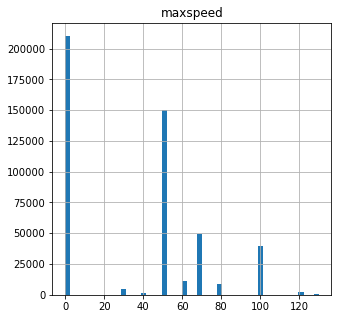

In [12]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(5,5))

In [13]:
sm.road_links['highway'].unique()

array(['trunk', 'secondary', 'primary', 'motorway_link', 'trunk_link',
       'primary_link', "['trunk', 'primary']", 'motorway',
       'secondary_link', "['secondary', 'trunk_link']",
       "['secondary', 'secondary_link']",
       "['secondary', 'motorway_link']", "['primary', 'trunk_link']",
       "['primary_link', 'primary']", "['secondary', 'primary_link']",
       "['motorway', 'trunk']", "['motorway', 'motorway_link']",
       "['trunk_link', 'motorway_link']", "['motorway', 'primary']",
       "['trunk', 'trunk_link']", "['trunk', 'motorway_link']",
       "['primary', 'motorway_link']", "['secondary_link', 'trunk_link']",
       "['trunk_link', 'primary']", "['primary_link', 'secondary_link']",
       "['primary_link', 'trunk_link']",
       "['secondary', 'primary_link', 'secondary_link']",
       "['secondary', 'trunk']", "['secondary_link', 'motorway_link']",
       "['secondary', 'primary']", "['motorway', 'trunk', 'primary']",
       "['primary_link', 'motorway_link']"

In [14]:
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
temp = sm.road_links.loc[(sm.road_links['maxspeed']!=default_speed) &
                         (sm.road_links['highway'].isin(main_types))
                        ].set_index('highway', drop=True)
weighted_speeds = temp.groupby(temp.index).apply(
    lambda x: int(np.average(x.maxspeed, weights=x.length)))
weighted_speeds

highway
motorway          112
motorway_link      80
primary            68
primary_link       68
secondary          57
secondary_link     60
trunk              96
trunk_link         70
dtype: int64

In [15]:
weighted_speeds.mean()

76.375

In [16]:
# On German motorways without speed limit MIV average speed is 125 km/h
# https://www.zukunft-mobilitaet.net/171117/analyse/gefahrene-geschwindigkeiten-auf-autobahnen-ohne-tempolimit-verteilung-deutschland/
sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                  (sm.road_links['highway']=='motorway'), 'maxspeed'] = 125
# All other road types are attributed according to the mean speed limit for their type
main_types = [t for t in list(sm.road_links['highway'].unique()) if not t.startswith('[')]
for t in main_types:
    try:
        sm.road_links.loc[(sm.road_links['maxspeed']==default_speed) &
                          (sm.road_links['highway']==t), 'maxspeed'] = weighted_speeds[t]
    except KeyError:
        print('No benchmark speed for highway type ' + t)
# The rest is a mix of all road types
sm.road_links['maxspeed'] = sm.road_links['maxspeed'].replace(
    default_speed, int(weighted_speeds.mean()))

array([[<AxesSubplot:title={'center':'maxspeed'}>]], dtype=object)

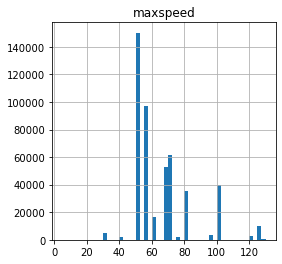

In [5]:
# Number of links (not length) with specified speeds
sm.road_links.hist(column='maxspeed', bins=50, figsize=(4,4))

In [7]:
# Generate time for road links in seconds
# Manual calibration with Google maps (see below)
# shows that traffic flow is slower than the speed limits
road_speed_calibration = 0.8
sm.road_links["time"] = sm.road_links["length"] / 1000 / \
    (sm.road_links["maxspeed"] * road_speed_calibration) * 3600

In [8]:
sm.road_links.sample(4)

,a,b,maxspeed,length,time,geometry,lanes
index,,,,,,,
rl_210881,343216049,98983781,50,95,8.550000,"LINESTRING (13.41197 52.54099, 13.41200 52.54014)","[3, 2]"
rl_96919,6665424797,262558678,50,1211,108.990000,"LINESTRING (9.51303 48.00808, 9.50339 48.01567)",None
rl_423046,289348532,3326907407,70,29,1.864286,"LINESTRING (10.23309 52.30268, 10.23308 52.30294)",6
rl_268992,1596358477,1615546370,50,386,34.740000,"LINESTRING (7.02836 51.58762, 7.03389 51.58742)","[3, 2]"


### Alter road access/egress links

In [9]:
# There has been assigned a static time value in prep20
sm.zone_to_road.sample()

,a,b,direction,distance,speed,time,geometry
index,,,,,,,
637,DEB1A,5155468302,access,0,5,0,"LINESTRING (7.84267 50.26328, 7.84647 50.26401)"


In [10]:
# ASSUMPTION: Assign a time
sm.zone_to_road['time'] = 5*60

## Apply road pathfinder in order to generate LoS table

In [11]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [12]:
sm.step_road_pathfinder(all_or_nothing=True,
                        od_set=od_set)

In [13]:
sm.car_los.sample(3)

,origin,destination,time,path,node_path,link_path,ntlegs
59338,DE407,DEG0F,12842.311940,"[DE407, 364897392, 158808136, 158810399, 31746...","[364897392, 158808136, 158810399, 317464850, 2...","[rl_474195, rl_474879, rl_414659, rl_414374, r...","[(DE407, 364897392), (14208444, DEG0F)]"
60255,DE40A,DE254,18894.128040,"[DE40A, 29653092, 29653091, 29653089, 10400496...","[29653092, 29653091, 29653089, 1040049661, 253...","[rl_421110, rl_421108, rl_448185, rl_244513, r...","[(DE40A, 29653092), (1540157602, DE254)]"
90969,DE943,DED43,19480.736223,"[DE943, 26869985, 26869977, 31065896, 28662712...","[26869985, 26869977, 31065896, 2866271244, 310...","[rl_83932, rl_83929, rl_85087, rl_325712, rl_8...","[(DE943, 26869985), (268667769, DED43)]"


In [14]:
sm.car_los.shape

(160801, 7)

In [15]:
# Verify with Google maps routing
# Berlin (DE300) - Stade (DE939): 4h22m, 354km
# Berlin (DE300) - Stuttgart (DE111): 6h37m, 632km
# Berlin (DE300) - Stendal (DEE0D): 2h08m, 125km
# Stade - Stuttgart: 7h45m, 687km
# Stendal - Stuttgart: 6h11m, 574km
# Stendal - Stade: 3h22m, 231km
od = ['DE300', 'DE939', 'DE111', 'DEE0D']
for _, row in sm.car_los.loc[(sm.car_los['origin'].isin(od)) &
                             (sm.car_los['destination'].isin(od))].iterrows():
    print(row['origin'] + ' - ' + row['destination'] + ': '
          + str(np.round(row['time']/3600,1)) + ', '
          + str(int(sm.road_links.loc[row['link_path'], 'length'].sum()/1000)) + 'km')

DE111 - DE111: 0.0, 0km
DE111 - DE300: 6.9, 631km
DE111 - DE939: 7.7, 689km
DE111 - DEE0D: 7.3, 588km
DE300 - DE111: 6.8, 631km
DE300 - DE300: 0.0, 0km
DE300 - DE939: 4.3, 361km
DE300 - DEE0D: 2.6, 134km
DE939 - DE111: 7.6, 688km
DE939 - DE300: 4.2, 355km
DE939 - DE939: 0.0, 0km
DE939 - DEE0D: 3.6, 274km
DEE0D - DE111: 7.2, 586km
DEE0D - DE300: 2.6, 134km
DEE0D - DE939: 3.7, 275km
DEE0D - DEE0D: 0.0, 0km


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

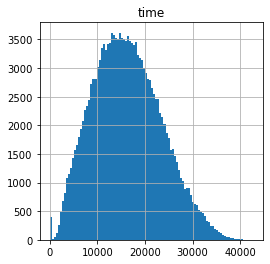

In [16]:
sm.car_los.hist(column='time', bins=100, figsize=(4,4))

In [17]:
# Drop inner-cell connections
sm.car_los = sm.car_los[sm.car_los['time']!=0]
sm.car_los.shape

(160400, 7)

## Add various attributes to LoS table

In [18]:
# Disaggregate into in-vehicle time and access/egress
sm.analysis_car_time()
print(sm.car_los.columns)

Index(['origin', 'destination', 'time', 'path', 'node_path', 'link_path',
       'ntlegs', 'access_time', 'in_vehicle_time'],
      dtype='object')


In [19]:
# Add distances car
len_dict = sm.road_links['length'].to_dict()
sm.car_los['length'] = sm.car_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [20]:
# Add route_type = 'car' in car_los
sm.analysis_car_route_type()

In [21]:
sm.car_los['ntransfers'] = 0

In [22]:
# Car is always available
sm.car_los['accessibility'] = 1

### Car ownership and accessibility
Car ownership from the German federal statistical office GENESIS data base table 46251-0006: "Kraftfahrzeugbestand: Kreise, Stichtag, Kraftfahrzeugarten". Download at Nov. 26th 2020. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [34]:
# Load the table
cars = pd.read_excel(input_path + 'spatial_car_ownership_2017_GENESIS.xlsx')
cars['sum_MIT'] = cars['Krafträder'] + cars['Pkw']
cars['lau_id'] = cars['lau_id'].astype(str)
cars['sum_MIT'] = cars['sum_MIT'].replace({'--': 0}).astype(int)
cars.set_index('lau_id', drop=True, inplace=True)
lau_car_dict = cars['sum_MIT'].to_dict()
sm.zones['cars'] = sm.zones['lau_id'].map(lau_car_dict)
sm.zones.sample(2)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry,cars
index,,,,,,,,,,
DEE08,DE,Burgenlandkreis,3,DEE08,180190,1413.75,3.0,15084,"MULTIPOLYGON (((12.17090 51.27551, 12.16634 51...",109048
DEB17,DE,Mayen-Koblenz,3,DEB17,214259,817.69,3.0,7137,"POLYGON ((7.59835 50.46456, 7.60295 50.46337, ...",144999


In [35]:
# Empty rows
print(len(sm.zones.loc[sm.zones['cars'].isna()]))
sm.zones.loc[sm.zones['cars']<sm.zones['population']/3]

0


,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry,cars
index,,,,,,,,,,
DE91C,DE,Göttingen,3,DE91C,328074,1755.39,3.0,3159,"POLYGON ((10.67728 51.63838, 10.67664 51.63294...",0
DEB25,DE,Trier-Saarburg,3,DEB25,148945,1102.22,3.0,7235,"POLYGON ((6.71195 49.90481, 6.72201 49.89223, ...",0


Accessibility of cars is important for only those people who drive them. If I wanted to calculate it using only the population between age 18 and 75, I had to use different numbers for population.

Population by NUTS3 zone and age group from the German federal statistical office GENESIS data base table 12411-0017: "Bevölkerung: Kreise, Stichtag, Altersgruppen". Download at Jan. 29th 2021. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [36]:
# Replace empty rows with average density
sm.zones['car_density'] = sm.zones['cars'] / sm.zones['population']
sm.zones.loc[sm.zones['cars']==0, 'cars'] = \
    sm.zones['car_density'].mean() * sm.zones.loc[sm.zones['cars']==0, 'population']
sm.zones['car_density'] = sm.zones['cars'] / sm.zones['population']

In [37]:
sm.zones.groupby('urbanisation').agg({'car_density': 'mean'})

,car_density
urbanisation,
1.0,0.535343
2.0,0.652695
3.0,0.671949


In [38]:
# Set accessibility
ac_dict = sm.zones['car_density'].to_dict()
sm.car_los['accessibility'] = sm.car_los['origin'].map(ac_dict)

In [39]:
# There are two cities with more cars than inhabitants:
# Wolfsburg and Trier. However, accessibility cannot be larger 1
sm.car_los['accessibility'] = sm.car_los['accessibility'].apply(lambda a: min(1, a))

array([[<AxesSubplot:title={'center':'accessibility'}>]], dtype=object)

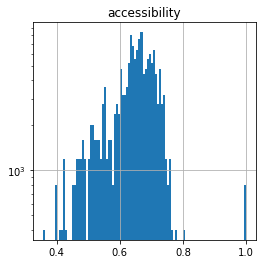

In [40]:
sm.car_los.hist(column='accessibility', bins=100, figsize=(4,4), log=True)

### Add cost to LoS table

In [23]:
def monetary_cost(length, rf, vc, ac, al, ec, el, sf):
    """ calculate monetary cost of travelling one O-D realtion within the LoS table
    :param length: length of main leg in meter
    :param df: regression factor for length (to be calibrated beforehand)
    :param vc: distance-specific transport cost
    :param ac: access cost
    :param al: access link length (m)
    :param ec: egress cost
    :param el: egress link length (m)
    :param sf: sharing factor (e.g. occupancy factor of a car)
    :return: monetary cost"""
    return (math.pow(length, rf) * vc + ac * al + ec * el) / sf

In [24]:
# Load list of cost elements
cars = pd.read_csv(input_path + 'level_of_service_ADAC_2019_autokostenuebersicht_47085.csv')
cars.sample(4)

,fix_cost,repair_cost,var_cost,acquisition_cost,eur_per_month,ct_per_km,model,model.1
1594,110,53,124,368,655,52.4,Caddy Beach 2.0 TDI SCR BMT,Caddy Beach 2.0 TDI SCR BMT
502,160,96,123,491,870,69.6,Edge 2.0 EcoBlue Trend 4x2 Automatik,Edge 2.0 EcoBlue Trend 4x2 Automatik
1424,126,105,161,552,944,75.5,V60 T5 Polestar Performance Momentum Geartronic,V60 T5 Polestar Performance Momentum Geartronic
1107,132,88,128,415,763,61.0,Grandland X 2.0 Diesel Business Innovation Aut...,Grandland X 2.0 Diesel Business Innovation Aut...


Take only perceived variable cost for distance-dependency.<br>
Assume monthly mileage of 15,000km / 12<br>
Additionally, there are fix cost which add up on every trip. Assume 3 trips per day as average.

In [26]:
# Prep
sm.car_los['price'] = 0
vc_car = cars['var_cost'].astype(int).mean() / (15000000/12) # in EUR/m
fix_car = cars['fix_cost'].astype(int).mean() / 30 / 3 # in EUR/trip with above assumption
parking_cost = {1: 5, 2: 0, 3: 0} # cost depending on urbanisation degree
# https://de.statista.com/statistik/daten/studie/254465/umfrage/preise-fuer-parkplaetze-in-deutschen-grossstaedten/
print(fix_car)
print(vc_car)

1.551890814081408
0.00011439257425742574


In [27]:
# ASSUMPTION: Average car occupancy is 1.5 in Germany
urb_dict = sm.zones['urbanisation'].to_dict()
sm.car_los['price'] = sm.car_los.apply(lambda df: monetary_cost(
    df['length'], 1, vc_car,
    0,0, # parking at home is for free
    parking_cost[urb_dict[df['destination']]], 1,
    1.5) + fix_car, axis=1)

In [28]:
sm.car_los.sample(2)

,origin,destination,time,path,node_path,link_path,ntlegs,access_time,in_vehicle_time,length,route_types,route_type,ntransfers,accessibility,price
80403,DE916,DE91A,4429.424406,"[DE916, 30530266, 3300956788, 30566120, 305661...","[30530266, 3300956788, 30566120, 30566187, 266...","[rl_77574, rl_380405, rl_100518, rl_423488, rl...","[(DE916, 30530266), (299708779, DE91A)]",600,3829.424406,77715,"(car,)",car,0,1,7.478570
25041,DE21J,DE724,16630.917906,"[DE21J, 255947675, 69471735, 1626295973, 25594...","[255947675, 69471735, 1626295973, 255949571, 2...","[rl_60451, rl_171048, rl_303499, rl_61739, rl_...","[(DE21J, 255947675), (225314610, DE724)]",600,16030.917906,417199,"(car,)",car,0,1,33.368203


<AxesSubplot:xlabel='length', ylabel='price'>

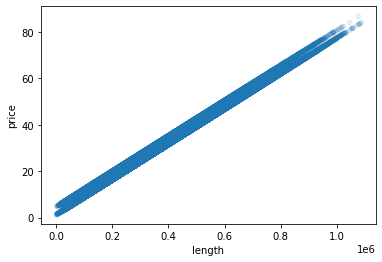

In [29]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

Instead of fix cost per trip, one can also assume ownership cost per hour of vehicle usage. This is also the approach chosen for the German federal governments transport study. In the methodical handbook gasoline cars have engine class weighted specific ownership cost of 0.71 EUR/h and diesel cars 0.99 EUR/h (other propulsion systems don't play a significant role). Multiplied with 2017's shares of gasoline and diesel cars (66.5%; 33.5%) this yields weighted average ownership cost of 0.8 EUR/h.

In [30]:
sm.car_los['price'] = sm.car_los['price'] - fix_car + \
    sm.car_los['time'].apply(lambda s: 0.8 * s / 3600)

<AxesSubplot:xlabel='length', ylabel='price'>

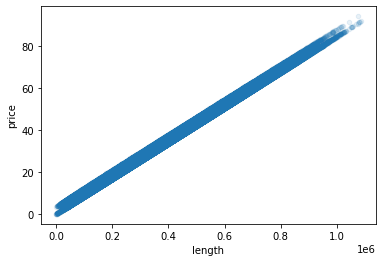

In [31]:
sm.car_los.plot.scatter(x='length', y='price', alpha=.1)

### Save model

In [32]:
# Ditch unneccessary columns
to_drop = ['alighting_links','alightings','all_walk','boarding_links','boardings',
           'footpaths','length_link_path','node_path','ntlegs','time_link_path','transfers',
           'pathfinder_session','gtime','reversed', 'broken_modes', 'path']
sm.car_los = sm.car_los.drop(to_drop, axis=1, errors='ignore')

In [33]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [34]:
sm.to_json(model_path + 'de_road_los',
           only_attributes=['car_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:08<00:00,  3.93it/s]


In [25]:
# Also save road links with imputated maxspeeds
sm.road_links["time"] = sm.road_links["time"].astype(int)
sm.to_json(input_path + 'de_road_network', only_attributes=
           ['road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 33/33 [02:06<00:00,  3.84s/it]
